In [1]:
from my_packages import *
%matplotlib inline
data_folder = "./data/"
time_tracking = Time_Tracking()

# load data

In [14]:
time_tracking.start_tracking()
dtypes = {'ip':'uint32','app':'uint16','device':'uint16','os':'uint16','channel':'uint16','is_attributed' : 'uint8'}
train_raw = pd.read_csv(data_folder + 'train_sample.csv', dtype = dtypes)
time_tracking.stop_tracking()

Time used: 0.0  minutes


There are limit number of features in the raw data. 

To select useful features, I first analyze how many unqiue values are in the raw data. 

Then I combine each two features and analyze its distribution. 

Finally, check the selected features by xgboost feature importance. 

# analyze feature class ratio

Text(0.5,0,"['app' 'device' 'os' 'channel' 'click_time_hour' 'click_time_dow'\n 'click_time_day']")

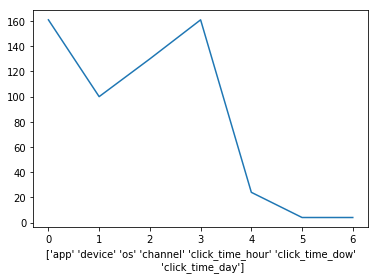

In [3]:
# add date features
train = train_raw.copy()
train = add_date_features(train, 'click_time')

# number of unique values for each feature
unique_col = train.drop(['is_attributed','click_time', 'ip', 'attributed_time'], axis = 1).columns
unique_len = [0]*len(unique_col)

for i, c in enumerate(unique_col):
    unique_len[i] = len(set(train[c]))

plt.figure()
plt.plot(np.arange(len(unique_col)), unique_len)
plt.xlabel(unique_col.values)

by analyzing the positive ratio for each feature, we found that 'app, device', 'app, channel' are likely to be good features. 

In [8]:
cols = ['ip', 'app', 'device', 'os', 'channel', 'click_time_hour', 'click_time_dow', 'click_time_day']

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


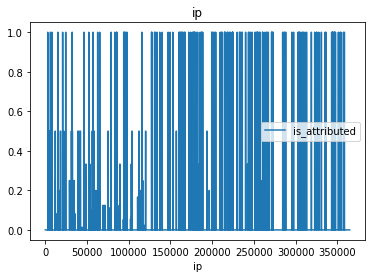

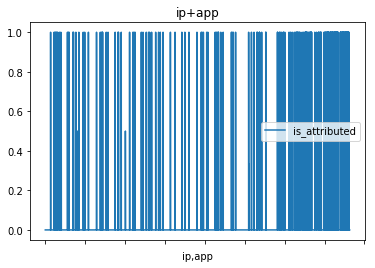

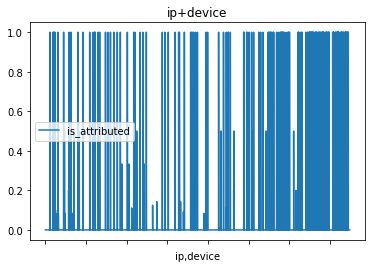

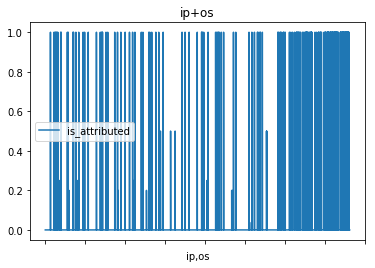

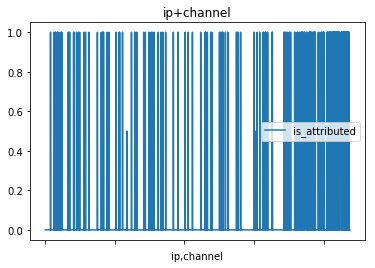

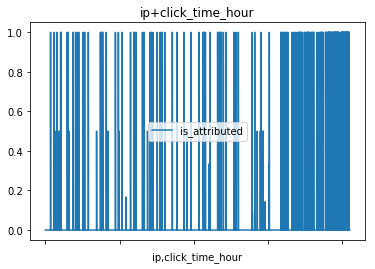

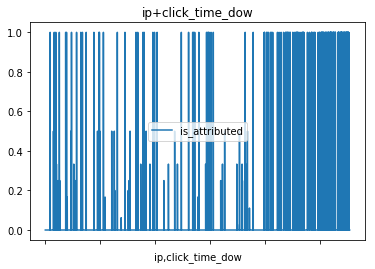

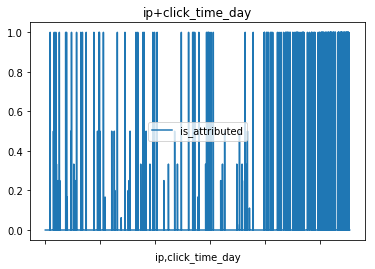

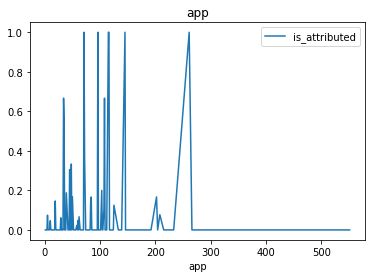

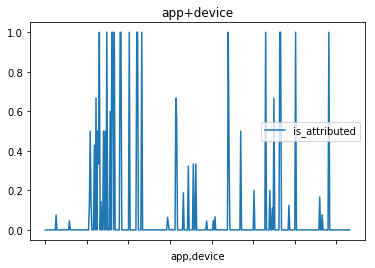

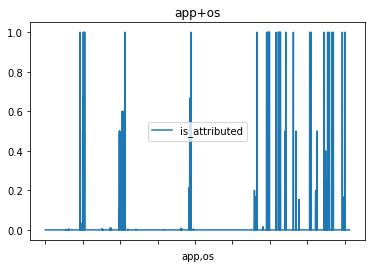

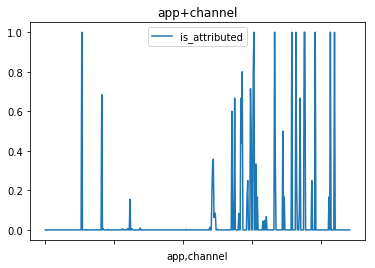

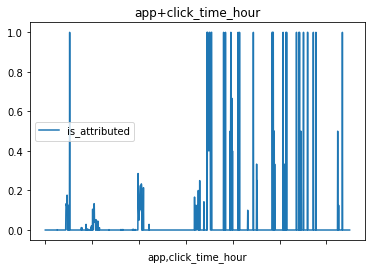

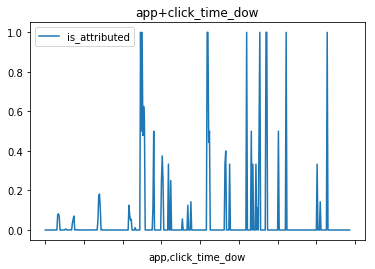

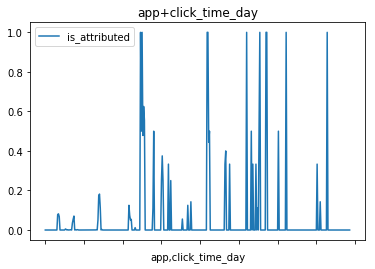

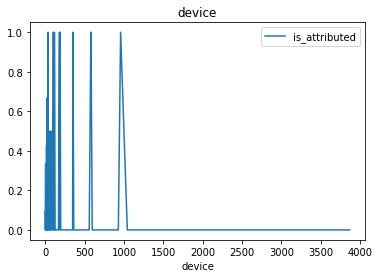

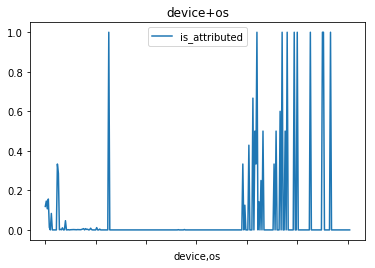

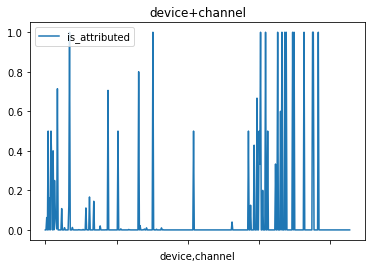

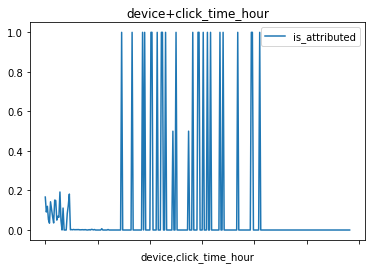

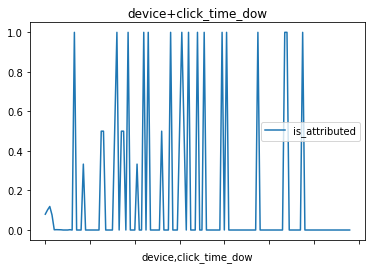

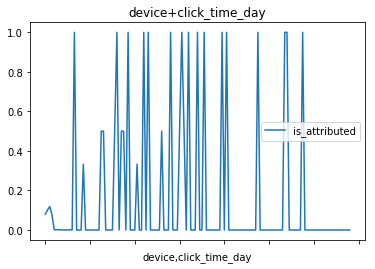

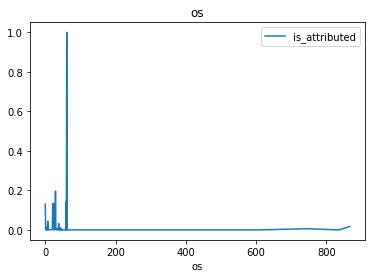

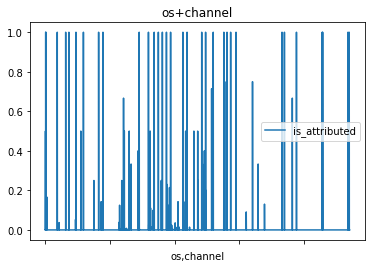

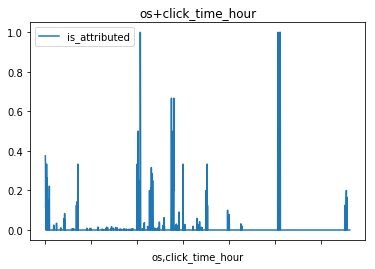

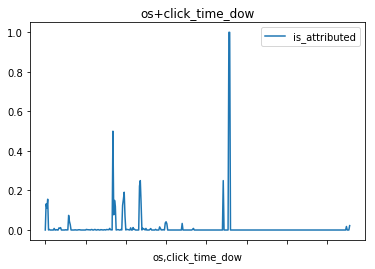

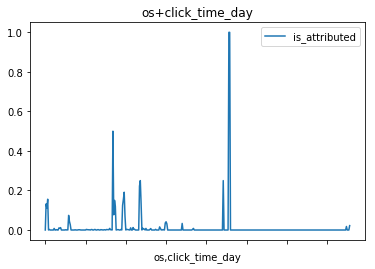

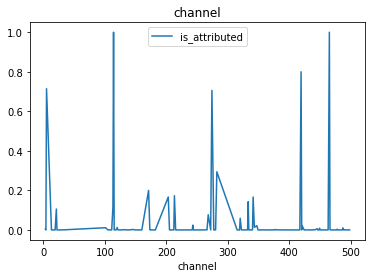

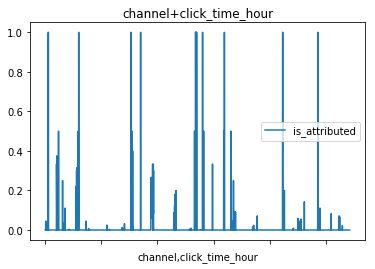

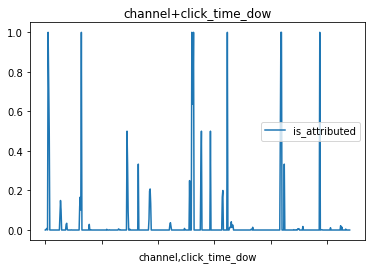

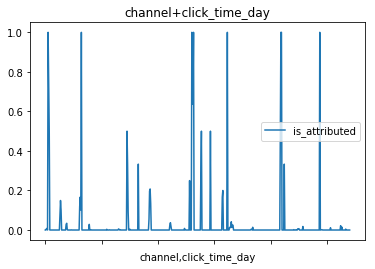

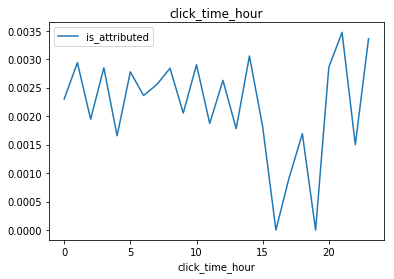

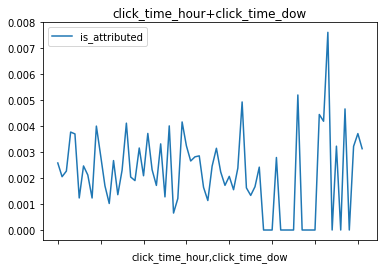

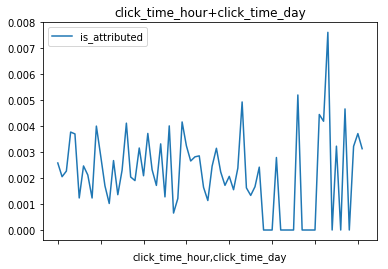

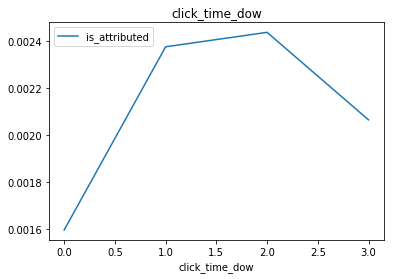

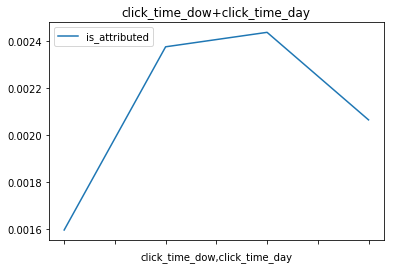

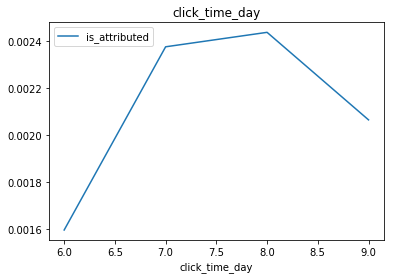

In [9]:
for i, c_a in enumerate(cols):
    for j, c_b in enumerate(cols):
        if i==j:
            train[[c_a, 'is_attributed']].groupby([c_a], as_index=True).mean().plot()
            plt.title(c_a)
        elif i < j:
            train[[c_a, c_b, 'is_attributed']].groupby([c_a, c_b], as_index=True).mean().plot()
            plt.title(c_a + '+' + c_b)
        else:
            continue

Good features are thoes that make clear boundary for different feature values. 

Thus, apart from original features, I select 'device + os', 'os+click_time_hour' as new features. 

# check feature importance

In [3]:
def add_combined_feat(df):
    df['os+device'] = [int(str(os)+str(dev)) for os, dev in zip(df['os'], df['device'])]
    df['os+hour'] = [int(str(os) + str(hour)) for os, hour in zip(df['os'],df['click_time_hour'])]
    return df

In [7]:
our_model = MyXgbModel()

train_feat = down_sample_train(train_raw)
train_feat = add_date_features(train_feat, 'click_time')
# train_feat = add_combined_feat(train_feat)

x = train_feat.drop(['click_time', 'attributed_time', 'is_attributed', 'os', 'device'], axis = 1)
y = train_feat['is_attributed']
train_param = {'eval_metric':'auc'}

np.random.seed(123)
cv, feat_importance = our_model.train(x, y, train_param)

print('cv:{}'.format(cv))

cv:0.9206774000000001


Text(0.5,1,'feature importance')

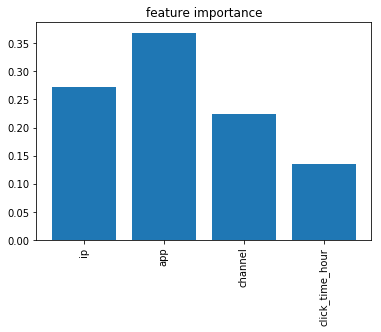

In [8]:
plt.bar(range(len(feat_importance)), feat_importance)
plt.xticks(range(len(feat_importance)), x.columns, rotation='vertical')
plt.title('feature importance')

From the result, features like 'click_time_day', 'click_time_dow', 'os', 'device' and combined features doesn't make greate influence on the auc. Considering the large size of our training data, I decide to keep the most important four features. 

# hyper tune

In [9]:
len(train_raw[train_raw['is_attributed']==0])/len(train_raw[train_raw['is_attributed']==1])

439.52863436123346

[0.9206774000000001, 0.9109738000000001, 0.8824949999999999, 0.8696778000000001, 0.8499616]


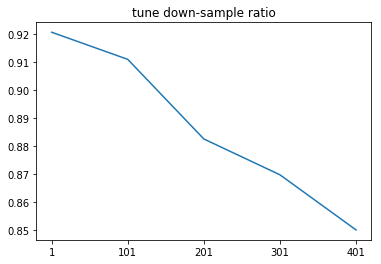

In [10]:
tune_auc = []
tune_range = np.arange(1, 500, 100)

for sample_ratio in tune_range:

    make_feat_param = {'sample_ratio':sample_ratio, 'has_target':True, 'do_sample':True}

    our_model = MyXgbModel()
    evaluate_feat = our_model.make_feat_pipeline(train_raw, make_feat_param)
    x = evaluate_feat.drop(['click_time', 'attributed_time', 'is_attributed', 'os', 'device'], axis = 1)
    y = evaluate_feat['is_attributed']

    param = {'eval_metric':'auc'}
    train_cv, _ = our_model.train(x, y, param)

    tune_auc.extend([train_cv])

plt.figure()
plt.plot(tune_range, tune_auc)
plt.xticks(tune_range)
plt.title('tune down-sample ratio')

print(tune_auc)

The auc drops as down-sample ratio increases, thus, I down sampled the negative class, which is the same size of the positive examples. 